## AdamW/SGDW benchmarking

This is to benchmark an implementation of https://arxiv.org/abs/1711.05101

In [ ]:
PATH = "/home/as/datasets/fastai.cifar10/cifar10/"

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt
%matplotlib inline

### Common stuff for all experiments

In [ ]:
def Get_SGD_Momentum(momentum=0.9):
    return lambda *args, **kwargs: optim.SGD(*args, momentum=momentum, **kwargs)

def Get_Adam():
    return lambda *args, **kwargs: optim.Adam(*args, **kwargs)

In [ ]:
import pickle

def save_list(fname, l):
    with open(fname, "wb") as fp:
        pickle.dump(l, fp)
        
def read_list(fname):
    with open(fname, "rb") as fp:
        return pickle.load(fp)

### Section 1: Plot loss trends of various scenarios

### This is a common function which does the training. 

The only thing it asks for is the optimizer, and the initial LR for that optimizer. Hence we are comparing optimizers keeping all things same.

In [ ]:
def experiment(optimizer, PATH, lr=1e-3, find_lr=False, use_wd_sched=False, wds=None, do_unfreeze=False, 
               norm_wds=False, wds_sched_mult=None):
    sz = 32
    bs = 120
    arch=resnet152
    cycle_len=2
    cycle_mult=2
    num_cycles = 4
    lr = lr
    
    if wds is None:
        weight_decay = 0.025 # As used in the paper https://arxiv.org/abs/1711.05101
    else:
        weight_decay = wds
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[1024, 512], opt_fn=optimizer)
    
    if find_lr:
        lrf=learn.lr_find()
        learn.sched.plot()
        return
    
    learn.fit(lr, 1, wds=weight_decay, use_wd_sched=use_wd_sched, norm_wds=norm_wds, wds_sched_mult=wds_sched_mult)
    print('Now with precompute as False')
    if do_unfreeze:
        learn.unfreeze()
        
    learn.precompute=False
    learn.fit(lr, num_cycles, wds=weight_decay, use_wd_sched=use_wd_sched, cycle_len=cycle_len, 
              cycle_mult=cycle_mult, norm_wds=norm_wds, wds_sched_mult=wds_sched_mult)
    
    loss = learn.sched.losses
    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss)
    plt.show()
    learn.sched.plot_lr()
    
    return learn.sched.losses, learn

In [ ]:
f = lambda x: np.array(x.layer_opt.lrs) / x.init_lrs

### SGDR/SGDW

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 367/417 [00:06<00:00, 53.78it/s, loss=6.84]
CPU times: user 12.9 s, sys: 6.71 s, total: 19.6 s          
Wall time: 13.8 s


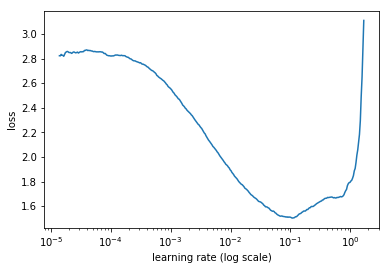

In [ ]:
%%time
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, PATH=PATH, find_lr=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.10252  1.04199  0.65605]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.1364   1.02446  0.65794]                       
[ 1.       1.08206  0.97455  0.6751 ]                       
[ 2.       1.15686  1.07465  0.63869]                       
[ 3.       1.15261  1.0353   0.65099]                       
[ 4.       1.10498  0.98328  0.67708]                       
[ 5.       1.06011  0.95787  0.68948]                       
[ 6.       1.19456  1.09135  0.63075]                       
[ 7.       1.19494  1.08135  0.63065]                       
[ 8.       1.19586  1.06903  0.64256]                       
[ 9.       1.16876  1.06267  0.65228]                       
[ 10.        1.13828   1.02387   0.65903]                   
[ 11.        1.11264   0.99049   0.67401]                   
[ 12.        1.07651   0.97051   0.68056]                   
[ 13.        1.06247   0.96359   0.68204]                   
[ 14.        1.22855   1.07522   0.63919]                   
[ 15.        1.21781   1.11106   0.63383]                   
[ 16.        1.20853   1

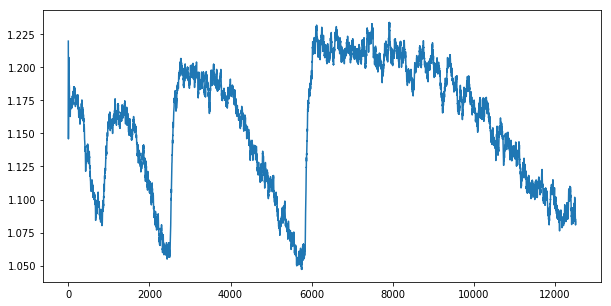

CPU times: user 23min 22s, sys: 6min 45s, total: 30min 8s
Wall time: 20min 7s


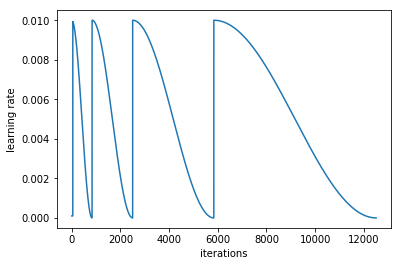

In [ ]:
%%time
# Without weight decay
sgdm = Get_SGD_Momentum()
loss_sgdm, _ = experiment(sgdm, PATH=PATH, lr=1e-2)
save_list('sgdm_loss.txt', loss_sgdm)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.09579  0.98664  0.65526]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.12314  0.95745  0.66409]                       
[ 1.       1.07291  0.93583  0.66964]                       
[ 2.       1.0849   0.93277  0.67599]                       
[ 3.       1.03306  0.91303  0.68145]                       
[ 4.       1.01905  0.88995  0.69058]                        
[ 5.       0.98558  0.89072  0.68849]                        
[ 6.       1.02736  0.91853  0.67559]                       
[ 7.       1.0194   0.90845  0.68353]                       
[ 8.       0.99881  0.89167  0.6869 ]                        
[ 9.       0.99231  0.86899  0.69524]                        
[ 10.        0.94204   0.84914   0.70357]                    
[ 11.        0.91504   0.83937   0.70585]                    
[ 12.        0.89167   0.83442   0.70883]                    
[ 13.        0.89308   0.83453   0.70982]                    
[ 14.        0.98872   0.88613   0.69048]                    
[ 15.        0.99674   0.88223   0.69593]                    
[ 16.        0

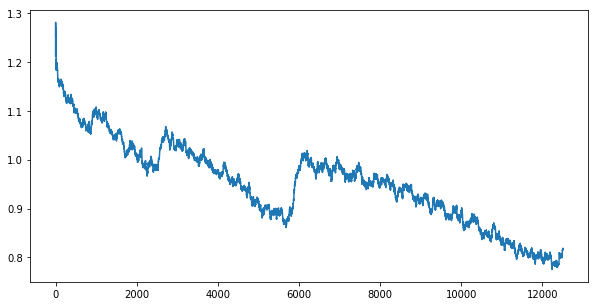

CPU times: user 23min 27s, sys: 6min 52s, total: 30min 19s
Wall time: 20min 29s


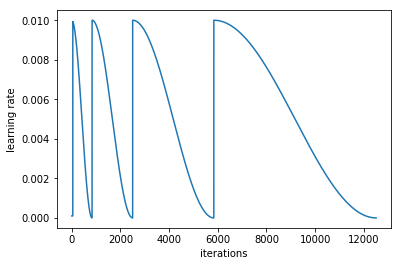

In [ ]:
%%time
# With weight decay
sgdmw = Get_SGD_Momentum()
loss_sgdmw, _ = experiment(sgdmw, PATH=PATH, lr=1e-2, use_wd_sched=True, norm_wds=True, wds_sched_mult=f)
save_list('sgdmw_loss.txt', loss_sgdmw)

### Adam/AdamW

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▍  | 311/417 [00:07<00:02, 42.19it/s, loss=5.74]


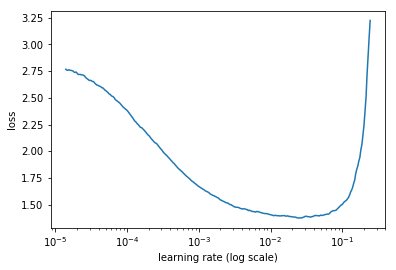

In [ ]:
adam = Get_Adam()
loss_adam = experiment(adam, PATH, find_lr=True)

**Train**

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.16206  1.10624  0.61597]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.25446  1.11698  0.62788]                       
[ 1.       1.17912  1.03288  0.65288]                       
[ 2.       1.27068  1.13769  0.62192]                       
[ 3.       1.24414  1.10389  0.63661]                       
[ 4.       1.18874  1.03594  0.65635]                       
[ 5.       1.1632   1.01193  0.6623 ]                       
[ 6.       1.2639   1.14672  0.61895]                       
[ 7.       1.2698   1.13121  0.61746]                       
[ 8.       1.26611  1.10718  0.63443]                       
[ 9.       1.22351  1.09626  0.63621]                       
[ 10.        1.20549   1.05746   0.65238]                   
[ 11.        1.17759   1.02645   0.66478]                   
[ 12.        1.14593   1.0053    0.67024]                   
[ 13.        1.1308    0.99884   0.67431]                   
[ 14.        1.27133   1.1385    0.62113]                   
[ 15.        1.24347   1.11354   0.63105]                   
[ 16.        1.24738   1

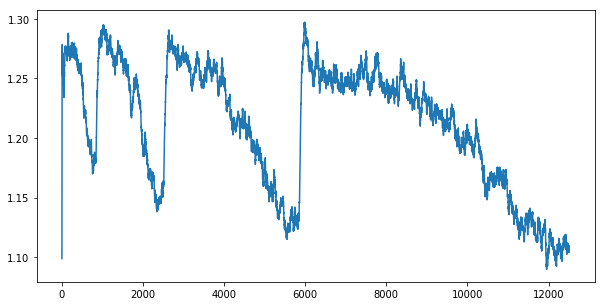

CPU times: user 23min 18s, sys: 6min 59s, total: 30min 17s
Wall time: 20min 23s


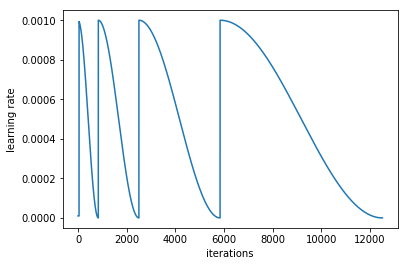

In [ ]:
%%time
# Without weight decay
adam = Get_Adam()
loss_adam, _ = experiment(adam, PATH, 1e-3)
save_list('adam_loss.txt', loss_adam)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.05115  0.96719  0.6628 ]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.08162  0.94352  0.67183]                       
[ 1.       0.99748  0.89464  0.6881 ]                        
[ 2.       1.0483   0.91754  0.67679]                       
[ 3.       1.02091  0.89119  0.68889]                        
[ 4.       0.95075  0.85186  0.70327]                        
[ 5.       0.90177  0.84354  0.70506]                        
[ 6.       1.00654  0.89183  0.68552]                        
[ 7.       0.99001  0.88197  0.69018]                        
[ 8.       0.96011  0.87726  0.69534]                        
[ 9.       0.96041  0.85465  0.70427]                        
[ 10.        0.90791   0.84278   0.70377]                    
[ 11.        0.87729   0.82705   0.71131]                    
[ 12.        0.86129   0.81556   0.71369]                    
[ 13.        0.84167   0.81839   0.71319]                    
[ 14.        0.96958   0.88032   0.69177]                    
[ 15.        0.96295   0.86398   0.69831]                    
[ 16.     

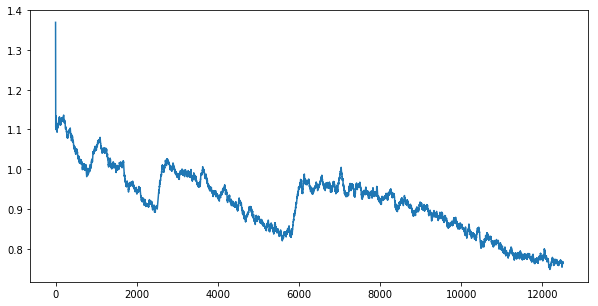

CPU times: user 23min 25s, sys: 7min, total: 30min 26s
Wall time: 20min 39s


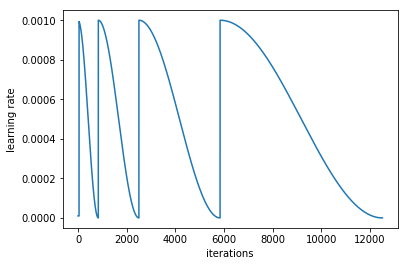

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
loss_adamw, _ = experiment(adamw, PATH, 1e-3, use_wd_sched=True, norm_wds=True, wds_sched_mult=f)
save_list('adamw_loss.txt', loss_adamw)

### Differential Learning and Weight Decay

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.25343  1.04188  0.63175]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.12512  0.96615  0.66171]                       
[ 1.       1.05414  0.92497  0.6746 ]                       
[ 2.       1.06102  0.92863  0.67649]                       
[ 3.       1.0196   0.90395  0.68185]                       
[ 4.       0.9773   0.87001  0.69395]                        
[ 5.       0.92542  0.85536  0.70188]                        
[ 6.       1.0287   0.91618  0.67996]                       
[ 7.       0.99776  0.89601  0.68482]                        
[ 8.       0.95506  0.87979  0.69028]                        
[ 9.       0.95912  0.85556  0.70357]                        
[ 10.        0.9116    0.84213   0.70575]                    
[ 11.        0.88703   0.82763   0.70784]                    
[ 12.        0.84927   0.81854   0.71081]                    
[ 13.        0.85036   0.81479   0.7128 ]                    
[ 14.        0.98082   0.87497   0.69147]                    
[ 15.        0.95896   0.87572   0.69266]                    
[ 16.        

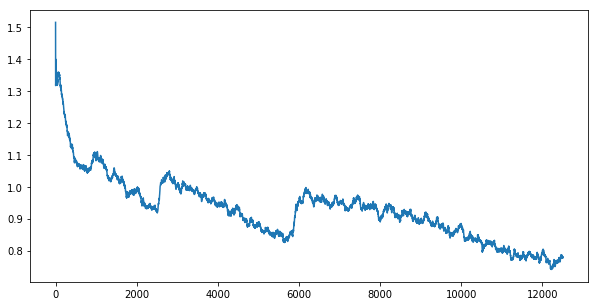

CPU times: user 23min 26s, sys: 7min, total: 30min 27s
Wall time: 20min 38s


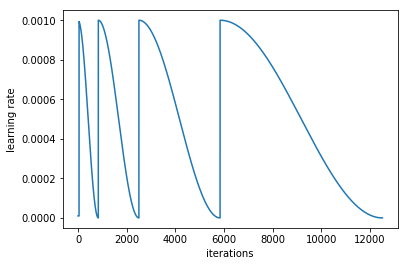

In [ ]:
%%time
adamw_diff = Get_Adam()
lr = 1e-3
wd = 0.025
loss_adamw_diff, _ = experiment(adamw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_sched=True, norm_wds=True, wds_sched_mult=f)
save_list('loss_adamw_diff.txt', loss_adamw_diff)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.38557  1.14619  0.59564]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.2172   1.00715  0.64316]                       
[ 1.       1.14248  0.97364  0.65169]                       
[ 2.       1.11695  0.95135  0.65883]                       
[ 3.       1.07557  0.93486  0.67143]                       
[ 4.       1.02138  0.90637  0.68105]                       
[ 5.       1.00519  0.90298  0.67976]                        
[ 6.       1.04351  0.92113  0.67302]                       
[ 7.       1.02742  0.9078   0.67788]                       
[ 8.       1.01408  0.88842  0.68651]                        
[ 9.       0.99154  0.87992  0.68998]                        
[ 10.        0.95499   0.86702   0.69603]                    
[ 11.        0.95086   0.85147   0.70109]                    
[ 12.        0.92738   0.84287   0.70387]                    
[ 13.        0.91638   0.84244   0.70496]                    
[ 14.        1.01557   0.90427   0.68561]                    
[ 15.        1.0169    0.88434   0.68641]                    
[ 16.        0.

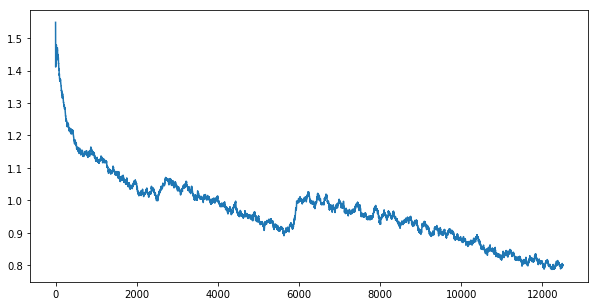

CPU times: user 23min 20s, sys: 6min 57s, total: 30min 18s
Wall time: 20min 27s


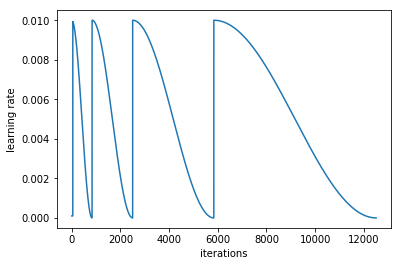

In [ ]:
%%time
sgdw_diff = Get_SGD_Momentum(0.9)
lr = 1e-2
wd = 0.025
loss_sgdw_diff, _ = experiment(sgdw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_sched=True, norm_wds=True, wds_sched_mult=f)
save_list('loss_sgdw_diff.txt', loss_sgdw_diff)

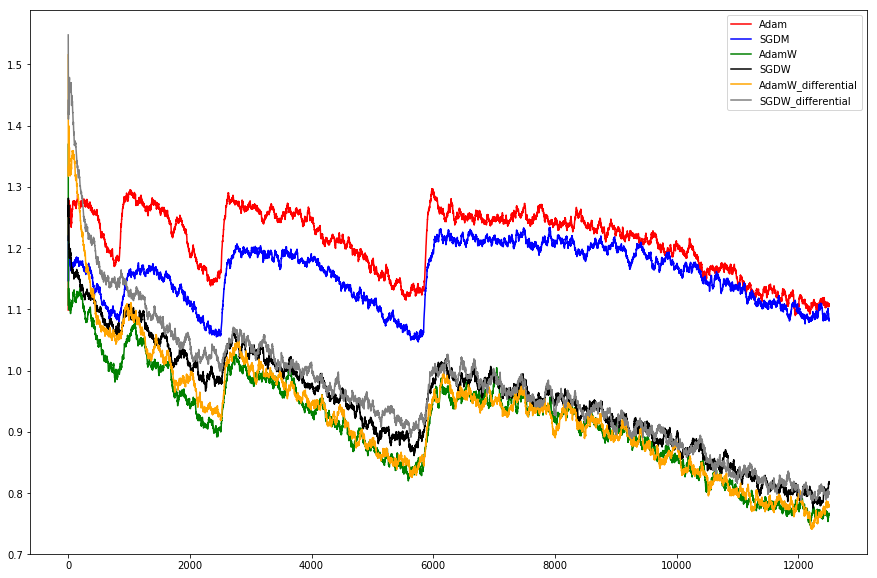

In [ ]:
fig=plt.figure(figsize=(15, 10))
plt.plot(loss_adam, c='red', label='Adam')
plt.plot(loss_sgdm, c='blue', label='SGDM')
plt.plot(loss_adamw, c='green', label='AdamW')
plt.plot(loss_sgdmw, c='black', label='SGDW')
plt.plot(loss_adamw_diff, c='orange', label='AdamW_differential')
plt.plot(loss_sgdw_diff, c='gray', label='SGDW_differential')
plt.legend()
plt.show()

### Section 2: Check for regularization of overfitting

In [ ]:
import time

In [ ]:
def check_overfitting(optimizer, PATH, sz, bs, lr, wds, use_wd_sched=True):
    
    arch=resnet50
    cycle_len=12
    cycle_mult=2
    num_cycles = 1

    tfms = tfms_from_model(arch, sz) # aug_tfms=transforms_side_on, max_zoom=1.1
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    # Turning off Dropout, adding 3 extra FC layers to help in overfitting.
    learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[1024, 512], ps=[0, 0, 0], opt_fn=optimizer)

    print("==== Let's overfit the model. Expectation: training loss should reduce but validation loss should stagnate.")
    learn.unfreeze()
    learn.fit(lr, num_cycles, cycle_len=cycle_len, cycle_mult=cycle_mult)
    print("==== Let's introduce weight regularization. Expectation: training loss and validation loss should reduce. Accuracy should improve.")
    learn.fit(lr, num_cycles, wds=wds, use_wd_sched=use_wd_sched,  cycle_len=cycle_len, cycle_mult=cycle_mult)
    time.sleep(5)

**AdamW on Cats & Dogs**

In [ ]:
%%time
PATH = "/home/as/datasets/fastai.dogscats/"
check_overfitting(Get_Adam(), PATH=PATH, sz=224, bs=96, lr=1e-3, wds=0.25, use_wd_sched=True)

**AdamW on Cifar10**

In [ ]:
%%time
PATH = "/home/as/datasets/fastai.cifar10/cifar10/"
check_overfitting(Get_Adam(), PATH=PATH, sz=32, bs=320, lr=1e-3, wds=0.45, use_wd_sched=True)

**Adam on Cifar10**

In [ ]:
%%time
PATH = "/home/as/datasets/fastai.cifar10/cifar10/"
check_overfitting(Get_Adam(), PATH=PATH, sz=32, bs=320, lr=1e-3, wds=0.45, use_wd_sched=False)

### Section 3: Tests after splitting the various parts of the regularizer

Separate weight regularization

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.88647  1.47695  0.51379]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.18962  0.96506  0.65635]                       
[ 1.       1.11035  0.92796  0.67093]                       
[ 2.       1.07023  0.92718  0.67153]                       
[ 3.       1.02732  0.89155  0.68552]                       
[ 4.       0.97336  0.87203  0.69375]                        
[ 5.       0.96949  0.87093  0.69494]                        
[ 6.       1.02327  0.89319  0.68591]                        
[ 7.       0.97858  0.87634  0.69097]                        
[ 8.       0.97534  0.85293  0.70149]                        
[ 9.       0.93149  0.84771  0.70268]                        
[ 10.        0.92056   0.82565   0.7124 ]                    
[ 11.        0.88824   0.82935   0.70972]                    
[ 12.        0.87601   0.81957   0.7129 ]                    
[ 13.        0.86438   0.81952   0.7121 ]                    
[ 14.        0.94136   0.86304   0.69673]                    
[ 15.        0.93918   0.83937   0.70506]                    
[ 16.       

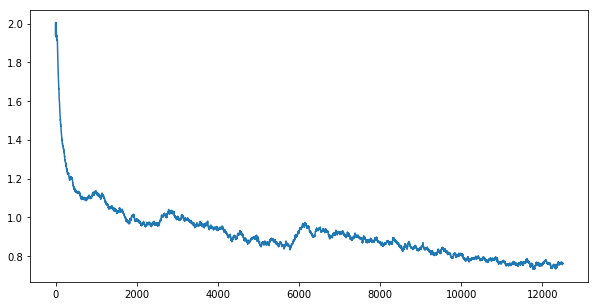

CPU times: user 23min 17s, sys: 6min 57s, total: 30min 14s
Wall time: 20min 22s


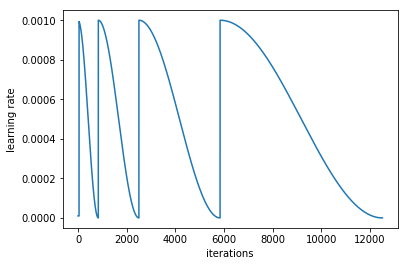

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
lr = [1e-5,1e-4,1e-3]
wd = [1e-7,1e-6,1e-5]
loss_adamw1, learn1 = experiment(adamw, PATH, lr, use_wd_sched=True, wds=wd, do_unfreeze=True)
save_list('adamw_loss1.txt', loss_adamw1)

With weight normalization

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.88573  1.45961  0.51915]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.19242  0.96442  0.65804]                       
[ 1.       1.09521  0.93045  0.66726]                       
[ 2.       1.09251  0.9283   0.67371]                       
[ 3.       1.01866  0.88867  0.68571]                       
[ 4.       0.98586  0.87771  0.69256]                        
[ 5.       0.96249  0.86489  0.69534]                        
[ 6.       1.00961  0.89263  0.68571]                       
[ 7.       0.99576  0.89136  0.68522]                        
[ 8.       0.96364  0.86692  0.69415]                        
[ 9.       0.93769  0.85321  0.70139]                        
[ 10.        0.90633   0.83638   0.70476]                    
[ 11.        0.88083   0.82757   0.70843]                    
[ 12.        0.85543   0.8223    0.71171]                    
[ 13.        0.86451   0.81844   0.7125 ]                    
[ 14.        0.94469   0.86198   0.69732]                    
[ 15.        0.91937   0.83931   0.70585]                    
[ 16.        

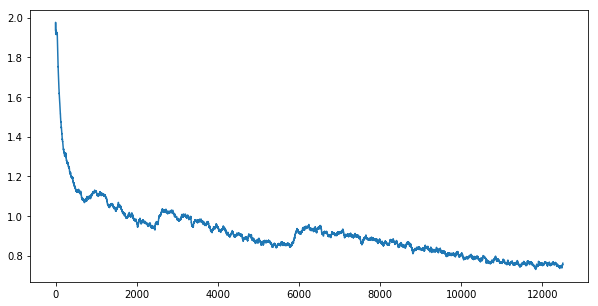

CPU times: user 23min 18s, sys: 6min 54s, total: 30min 13s
Wall time: 20min 22s


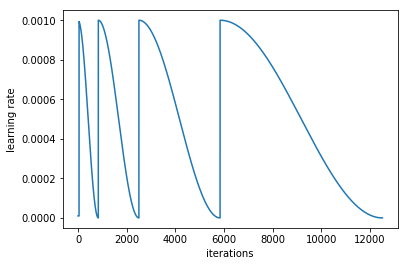

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
lr = [1e-5,1e-4,1e-3]
wd = [1e-5,1e-4,1e-3]
loss_adamw2, learn2 = experiment(adamw, PATH, lr, use_wd_sched=True, wds=wd, norm_wds=True, do_unfreeze=True)
save_list('adamw_loss2.txt', loss_adamw2)

With custom weight multiplier wds_sched_mult

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.91495  1.45581  0.51587]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.18653  0.97802  0.65179]                       
[ 1.       1.08818  0.92862  0.66667]                       
[ 2.       1.08374  0.92995  0.67014]                       
[ 3.       1.02608  0.89471  0.68403]                       
[ 4.       0.99638  0.86567  0.69564]                        
[ 5.       0.95797  0.86039  0.69444]                        
[ 6.       1.01389  0.89751  0.68373]                        
[ 7.       0.98849  0.87242  0.69206]                        
[ 8.       0.95054  0.85777  0.69434]                        
[ 9.       0.92966  0.85104  0.7003 ]                        
[ 10.        0.91      0.8263    0.71091]                    
[ 11.        0.87937   0.82215   0.71349]                    
[ 12.        0.86125   0.81632   0.71528]                    
[ 13.        0.85973   0.81679   0.71329]                    
[ 14.        0.96085   0.85626   0.69921]                    
[ 15.        0.93619   0.83843   0.70179]                    
[ 16.       

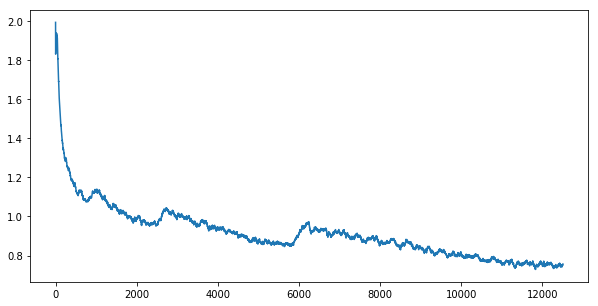

CPU times: user 23min 18s, sys: 6min 55s, total: 30min 14s
Wall time: 20min 22s


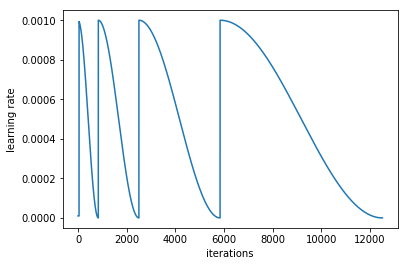

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
lr = [1e-5,1e-4,1e-3]
wd = [1e-5,1e-4,1e-3]
f = lambda x: np.array(x.layer_opt.lrs) / x.init_lrs
loss_adamw3, learn3 = experiment(adamw, PATH, lr, use_wd_sched=True, wds=wd, norm_wds=True, wds_sched_mult=f, do_unfreeze=True)
save_list('adamw_loss3.txt', loss_adamw3)

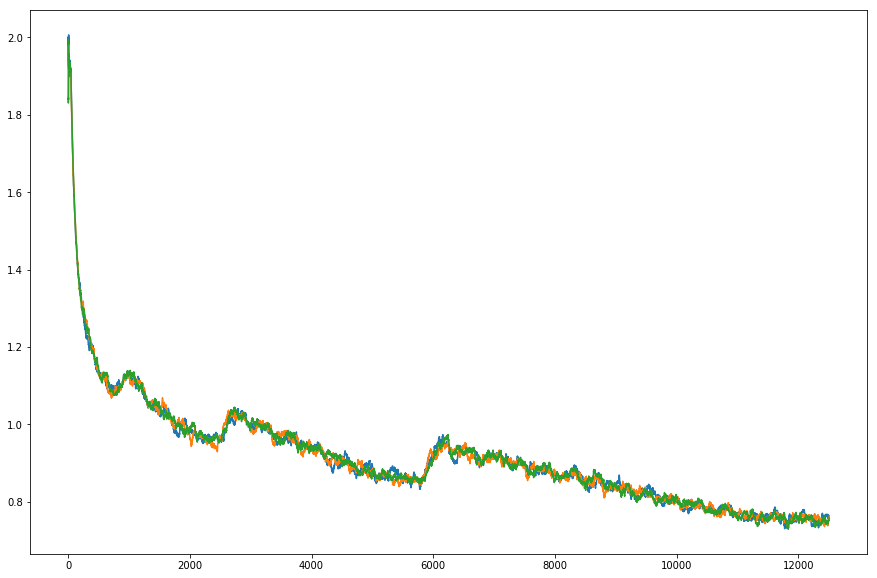

In [ ]:
fig = plt.figure(figsize=(15, 10))
plt.plot(loss_adamw1)
plt.plot(loss_adamw2)
plt.plot(loss_adamw3)
plt.show()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.89021  1.49814  0.50179]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.14415  0.98321  0.65486]                       
[ 1.       1.17225  1.1191   0.66458]                       
[ 2.       1.07665  0.9536   0.66597]                       
[ 3.       1.03984  0.93191  0.68105]                       
[ 4.       1.02686  0.9367   0.68978]                        
[ 5.       1.19762  1.20376  0.69494]                       
[ 6.       1.09923  0.97489  0.65992]                       
[ 7.       1.07333  0.95225  0.66568]                       
[ 8.       1.05902  0.93139  0.67877]                       
[ 9.       1.05099  0.92172  0.68036]                       
[ 10.        1.02277   0.95366   0.68105]                   
[ 11.        1.02635   0.95059   0.68829]                    
[ 12.        1.10198   1.06264   0.69732]                   
[ 13.        1.54751   1.5987    0.69246]                   
[ 14.        1.11582   1.00986   0.64722]                   
[ 15.        1.10576   0.97402   0.662  ]                   
[ 16.        1.08318  

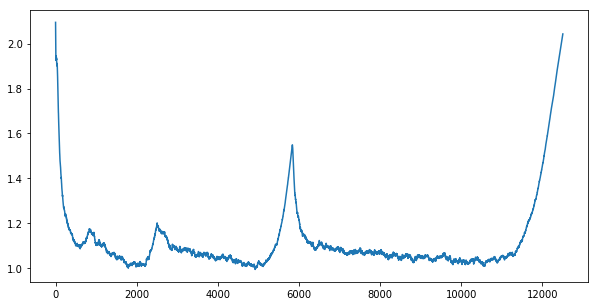

CPU times: user 23min 22s, sys: 6min 57s, total: 30min 19s
Wall time: 20min 27s


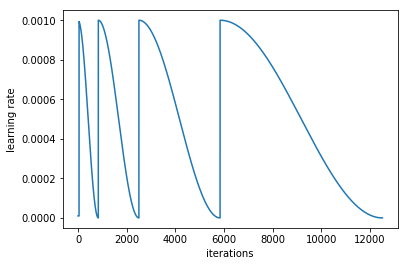

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
lr = [1e-5,1e-4,1e-3]
wd = [1e-5,1e-4,1e-3]
loss_adamw4, learn4 = experiment(adamw, PATH, lr, use_wd_sched=True, wds=wd, do_unfreeze=True)
save_list('adamw_loss4.txt', loss_adamw4)